# Lecture 15:  Random Forest 
### Data Science 1: CS 109A/STAT 121A/AC 209A/ E 109A <br> Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave
#### Harvard University <br> Fall 2017 <br> 

---


In [160]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble
sns.set(style="ticks")
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from io import StringIO
import pydot 
from IPython.display import display

from IPython.display import Image
import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

In [6]:
#--------  fit_and_plot_dt
# Fit decision tree with on given data set with given depth, and plot the data/model
# Input: 
#      fname (string containing file name)
#      depth (depth of tree)

def fit_and_plot_dt(x, y, depth, title, ax, plot_data=True, fill=True, color='Blues'):
    # FIT DECISION TREE MODEL
    dt = tree.DecisionTreeClassifier(max_depth = depth)
    dt.fit(x, y)

    # PLOT DECISION TREE BOUNDARY
    ax = plot_tree_boundary(x, y, dt, title, ax, plot_data, fill, color)
    
    return ax

In [7]:
#--------  plot_tree_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_tree_boundary(x, y, model, title, ax, plot_data=True, fill=True, color='Greens', alpha=0.1):
    if plot_data:
        # PLOT DATA
        ax.scatter(x[y==1,0], x[y==1,1], c='blue')
        ax.scatter(x[y==0,0], x[y==0,1], c='black')
    
    # CREATE MESH
    interval = np.arange(min(x.min(), y.min()),max(x.max(), y.max()),0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # PREDICT ON MESH POINTS
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # PLOT DECISION SURFACE
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    if fill:
        ax.contourf(x1, x2, yy, alpha=alpha, cmap=color)
    else:
        ax.contour(x1, x2, yy, alpha=alpha, cmap=color)
    
    # LABEL AXIS, TITLE
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    
    return ax

Create some fake data to illustrate the models 

In [30]:
npoints = 500 
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=npoints)
data = np.hstack((data, np.zeros((npoints, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = 1

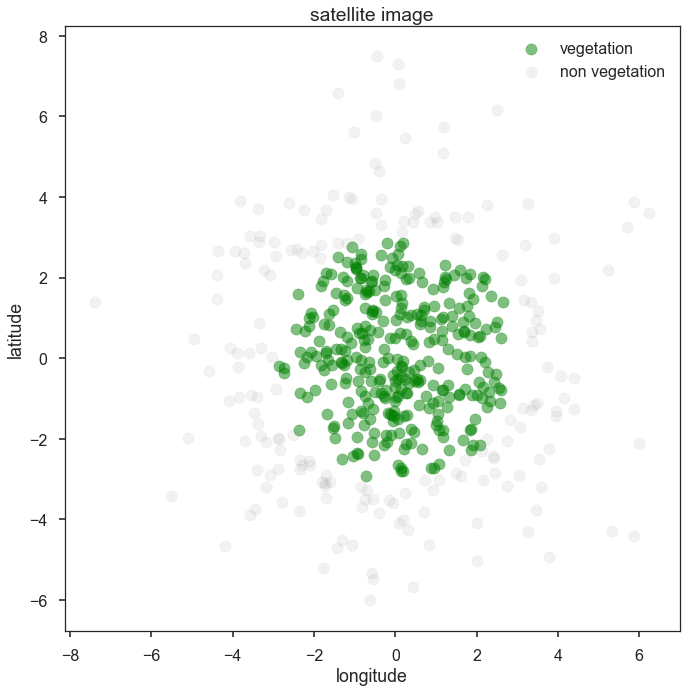

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
x = data[:, :-1]
y = data[:, -1]
ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_title('satellite image')
ax.legend()
plt.tight_layout()
plt.show() 

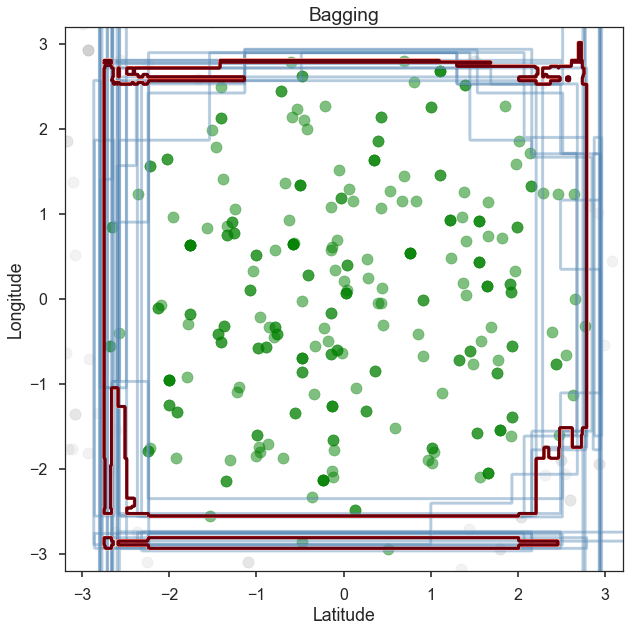

In [74]:
#Bagging
depth = None

fig, ax = plt.subplots(1, 1, figsize=(10, 10))


for i in range(8):
    sample_ind = np.random.choice(range(len(data)), len(data), replace=True)
    bootstrap = data[sample_ind]
    x = bootstrap[:, :-1]
    y = bootstrap[:, -1]
    ax = fit_and_plot_dt(x, y, depth, '', ax, plot_data=False, fill=False) 
 
#KIND OF CHEATING BELOW BECAUSE Bagging will create its own bootstrap samples
bag = ensemble.BaggingClassifier(n_estimators=100)
bag.fit(x, y)

ax = plot_tree_boundary(x, y, bag, 'Bagging', ax, plot_data=False, fill=False, color='Reds', alpha=1.)

ax.scatter(x[y == 1, 0], x[y == 1, 1], c='green', label='vegetation', alpha=0.5)
ax.scatter(x[y == 0, 0], x[y == 0, 1], c='gray', label='non vegetation', alpha=0.1)

ax.set_xlim(-3.2, 3.2)
ax.set_ylim(-3.2, 3.2)
plt.show() 

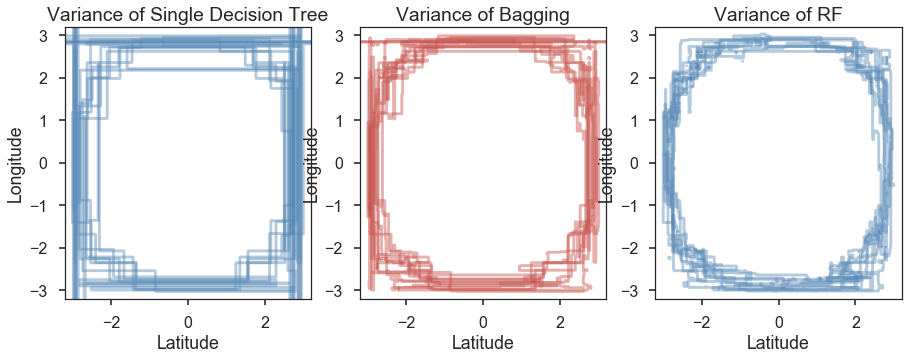

In [75]:
#Variance reduction: Baggining, RF, Tree
depth = None

fig, ax = plt.subplots(1, 3, figsize=(15, 5))


for i in range(8):
    new_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=npoints)
    new_data = np.hstack((new_data, np.zeros((npoints, 1))))
    new_data[new_data[:, 0]**2 + new_data[:, 1]**2 < 3**2, 2] = 1
    x = new_data[:, :-1]
    y = new_data[:, -1]

    ax[0] = fit_and_plot_dt(x, y, depth, 'Variance of Single Decision Tree', ax[0], plot_data=False, fill=False)
    
    bag = ensemble.BaggingClassifier(n_estimators=30)
    bag.fit(x, y)
    ax[1] = plot_tree_boundary(x, y, bag, 'Variance of Bagging', ax[1], plot_data=False, fill=False, color='Reds')
    
    rf = ensemble.RandomForestClassifier(n_estimators=30)
    rf.fit(x, y)
    ax[2] = plot_tree_boundary(x, y, rf, 'Variance of RF', ax[2], plot_data=False, fill=False, color='Blues')


    
ax[0].set_xlim(-3.2, 3.2)
ax[0].set_ylim(-3.2, 3.2)
ax[1].set_xlim(-3.2, 3.2)
ax[1].set_ylim(-3.2, 3.2)
ax[2].set_xlim(-3.2, 3.2)
ax[2].set_ylim(-3.2, 3.2)
plt.show() 

In [76]:
#Errors
data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=200)
data = np.hstack((data, np.zeros((200, 1))))
data[data[:, 0]**2 + data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(data[data[:, 0]**2 + data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x = data[:, :-1]
y = data[:, -1]

test_data = np.random.multivariate_normal([0, 0], np.eye(2) * 5, size=1000)
test_data = np.hstack((test_data, np.zeros((1000, 1))))
test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2, 2] = np.random.choice([0, 1], len(test_data[test_data[:, 0]**2 + test_data[:, 1]**2 < 3**2]), p=[0.2, 0.8])
x_test = test_data[:, :-1]
y_test = test_data[:, -1]

dt = tree.DecisionTreeClassifier()
dt.fit(x, y)
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))

bag_score = []
bag_oob = []
rf_score = []
rf_oob = []
for i in range(20, 320, 10):
    bag = ensemble.BaggingClassifier(n_estimators=i, oob_score=True)
    bag.fit(x, y)
    bag_score.append(bag.score(x_test, y_test))

    bag_oob.append(bag.oob_score_)
    
    rf = ensemble.RandomForestClassifier(n_estimators=i, oob_score=True)
    rf.fit(x, y)
    rf_score.append(rf.score(x_test, y_test))
    rf_oob.append(rf.oob_score_)

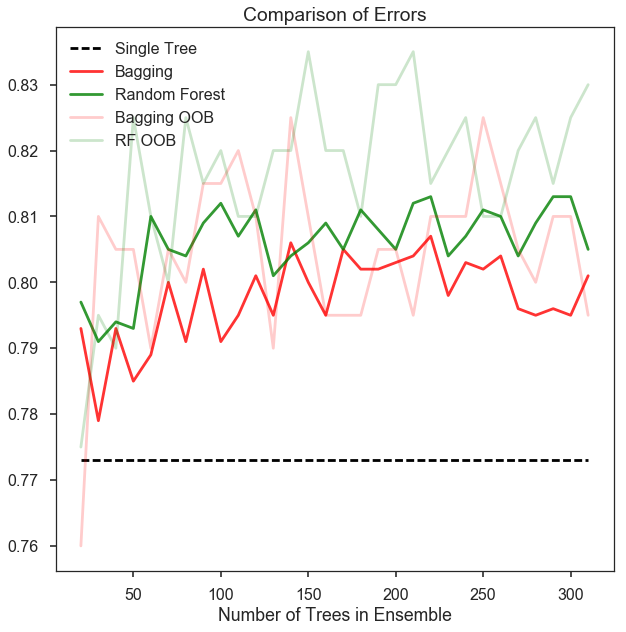

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
tree_score = np.array([dt.score(x_test, y_test)] * len(range(20, 320, 10)))
ax.plot(range(20, 320, 10), tree_score, color='black', linestyle='--', label='Single Tree')
ax.plot(range(20, 320, 10), bag_score, color='red', alpha=0.8, label='Bagging')
ax.plot(range(20, 320, 10), rf_score, color='green', alpha=0.8, label='Random Forest')
ax.plot(range(20, 320, 10), bag_oob, color='red', alpha=0.2, label='Bagging OOB')
ax.plot(range(20, 320, 10), rf_oob, color='green', alpha=0.2, label='RF OOB')
ax.set_title('Comparison of Errors')
ax.set_xlabel('Number of Trees in Ensemble')
ax.legend(loc='best')
plt.show()

### The heart data

In [228]:
df = pd.read_csv('data/Heart.csv', index_col=0)
df.head()


,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [229]:
df.dtypes

Age            int64
Sex            int64
ChestPain     object
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal          object
AHD           object
dtype: object

In [230]:
predictors_df = df[['Age', 'RestBP','Chol' , 'Fbs', 'RestECG', 'MaxHR', 'ExAng']]

#cat_predictors_df = df[['ChestPain','Thal', 'AHD', 'Sex']]
cat_predictors_df = df[['ChestPain','Thal',  'Sex']]
dummies_df = pd.get_dummies(cat_predictors_df)
dummies_df.shape

(303, 8)

Join Everything Together

In [231]:
dfpreds = predictors_df.join(dummies_df)
print(dfpreds.shape)
dfpreds.head()

(303, 15)


,Age,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Sex,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
1,63,145,233,1,2,150,0,1,0,0,0,1,1,0,0
2,67,160,286,0,2,108,1,1,1,0,0,0,0,1,0
3,67,120,229,0,2,129,1,1,1,0,0,0,0,0,1
4,37,130,250,0,0,187,0,1,0,1,0,0,0,1,0
5,41,130,204,0,2,172,0,0,0,0,1,0,0,1,0


In [232]:
X = dfpreds
y_l = df.iloc[:,-1]
D = {"Yes":1, "No":0}
D['No']
y = [1*D[y_] for y_ in y_l] 

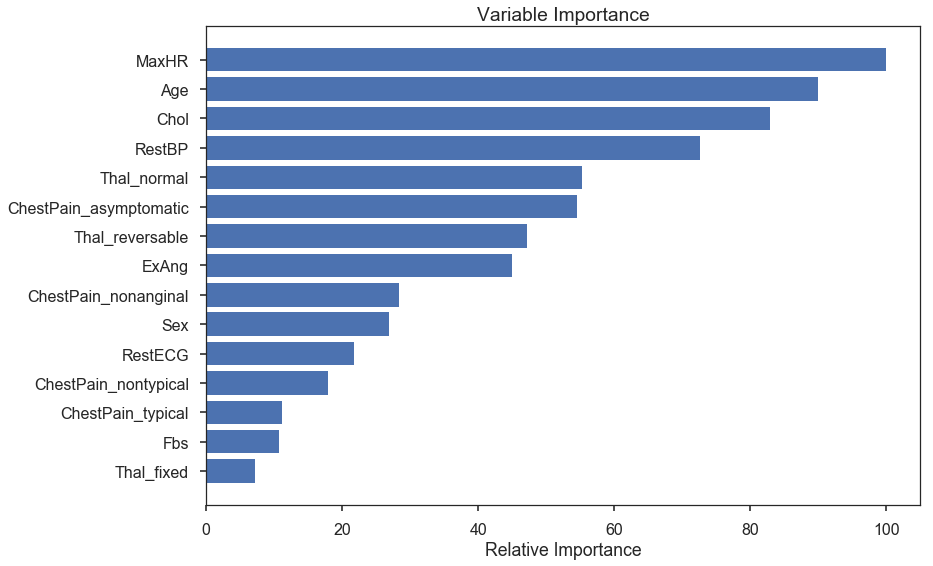

In [233]:
rf = ensemble.RandomForestClassifier(max_features= 1, n_estimators=50, oob_score=True)
rf.fit(X, y)

feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5





plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


plt.savefig('fig/variable_importance.png')

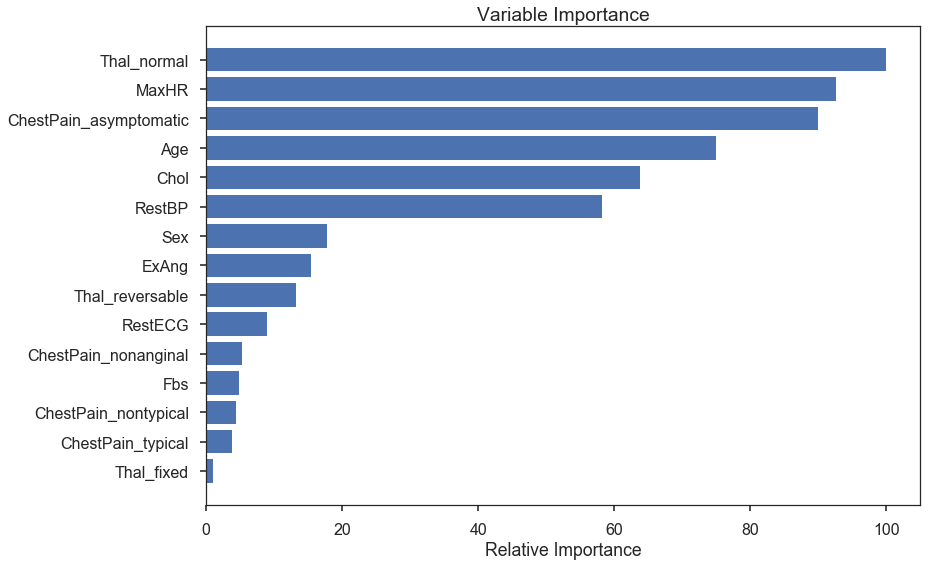

In [234]:
bg = ensemble.BaggingClassifier( n_estimators=20, oob_score=True)
bg.fit(X, y)


feature_importance = np.mean([
    tree.feature_importances_ for tree in bg.estimators_
], axis=0)



feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5





plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')



plt.savefig('fig/variable_importance_bagging.png')

### Bagging. All trees are correlated ! 

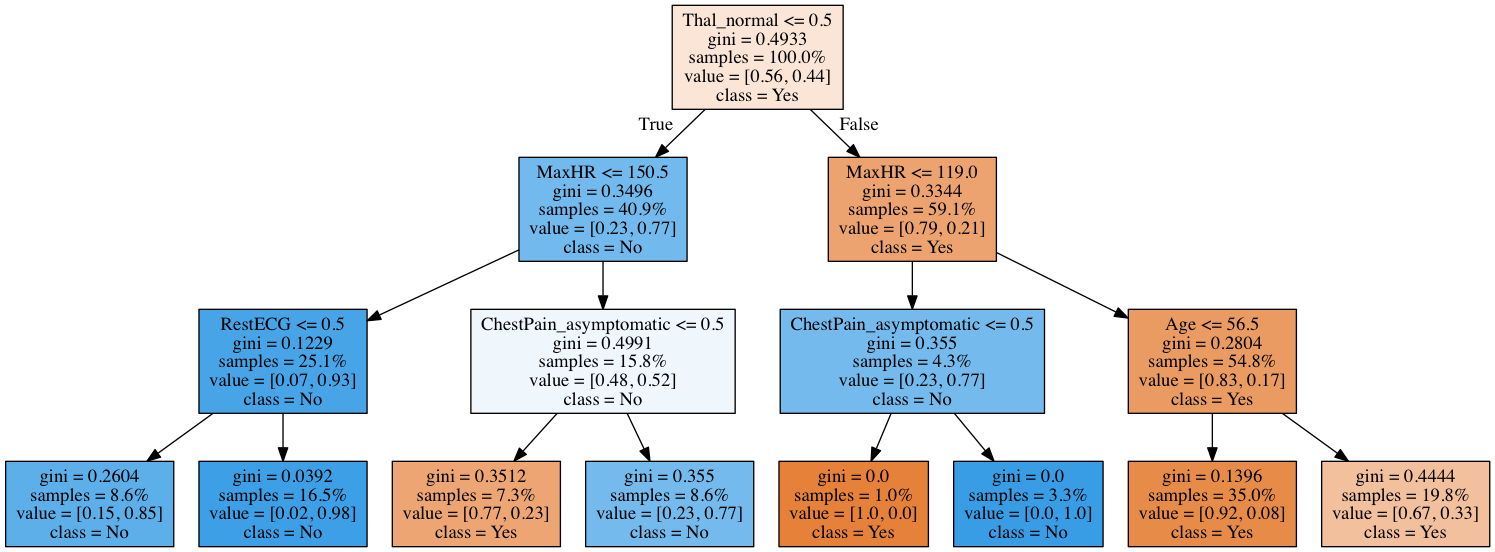

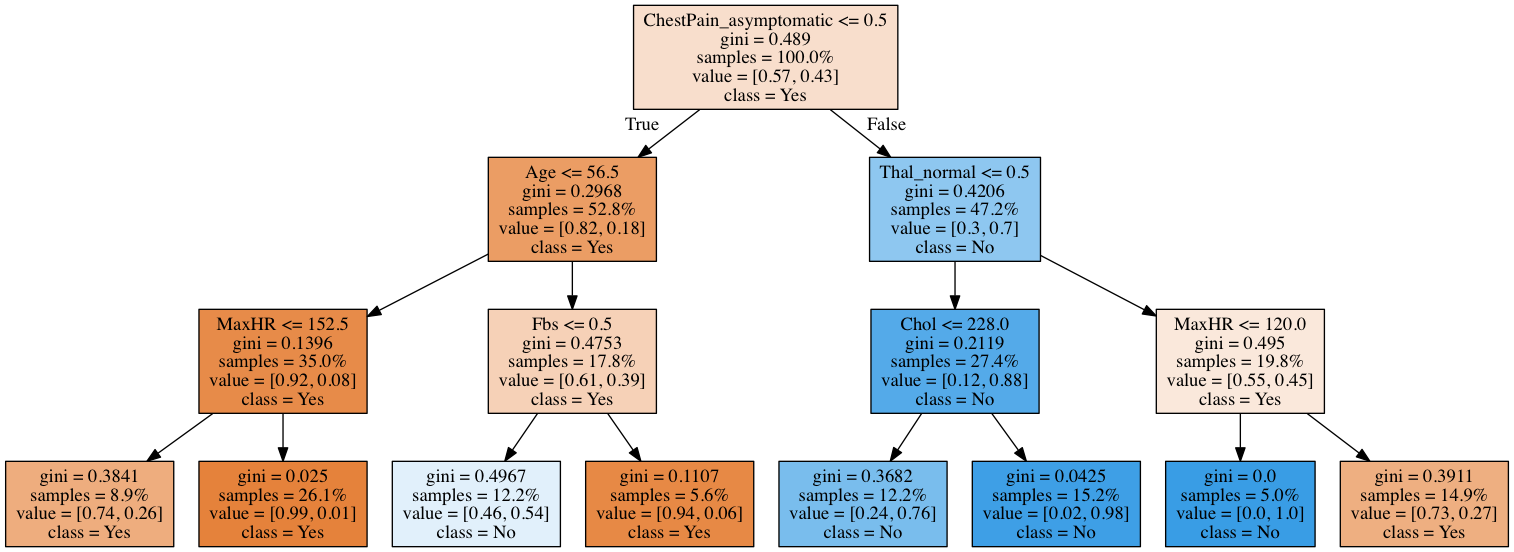

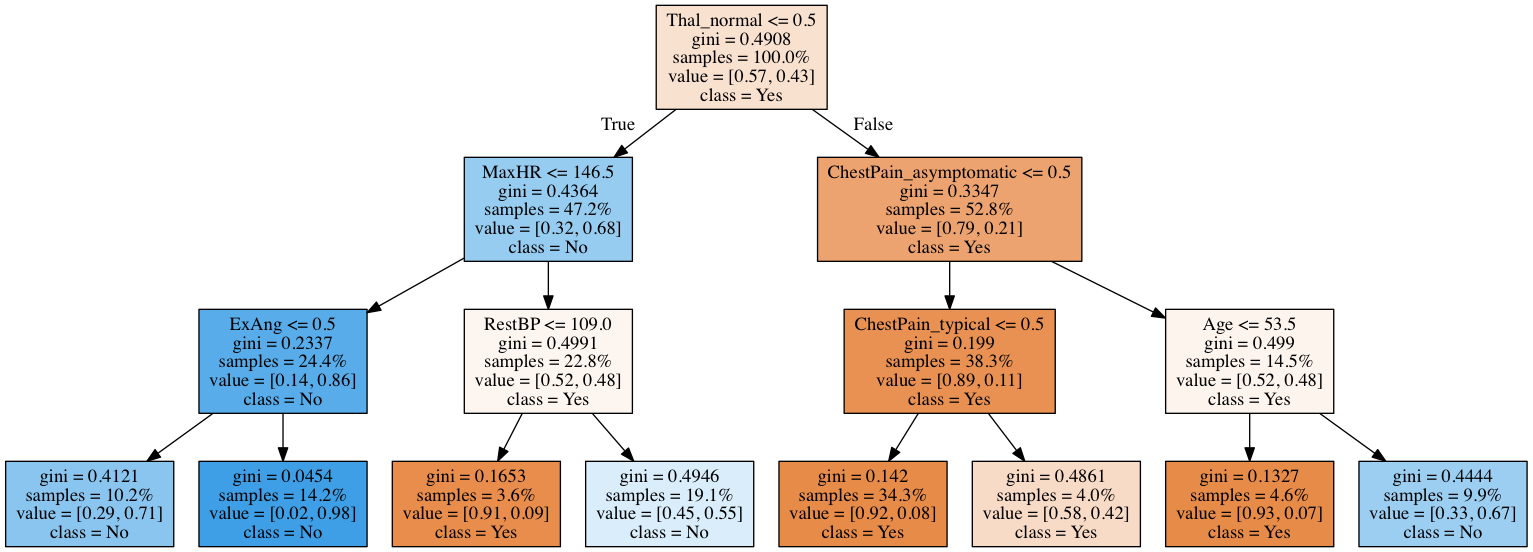

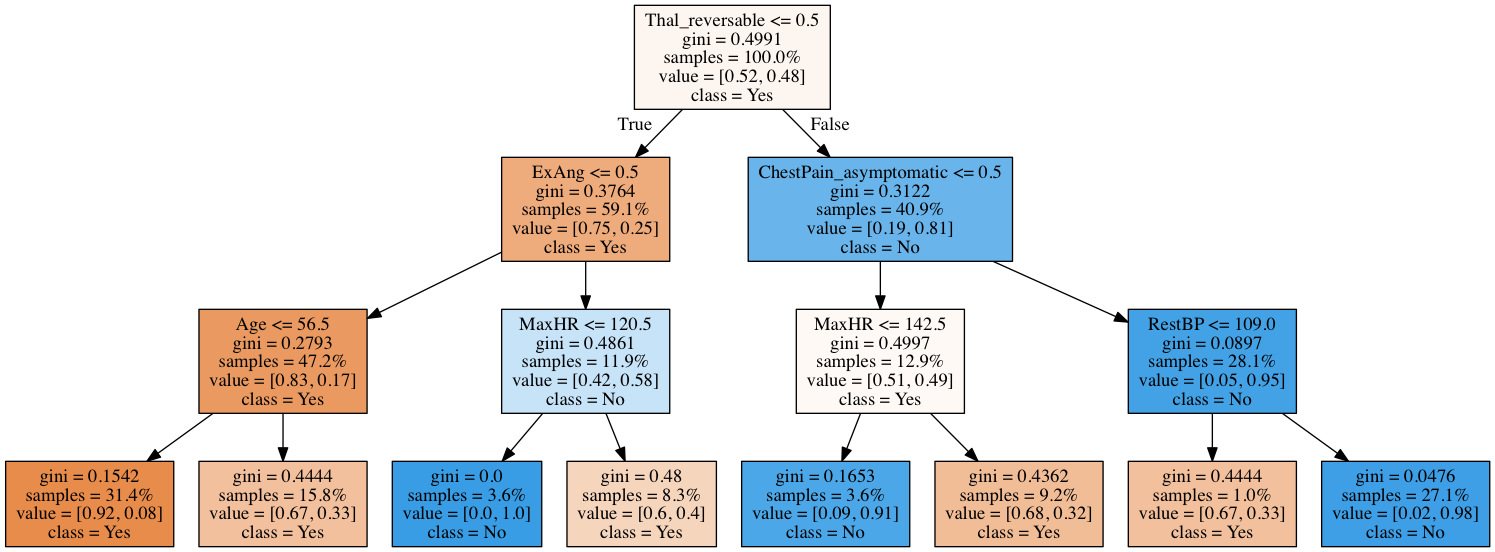

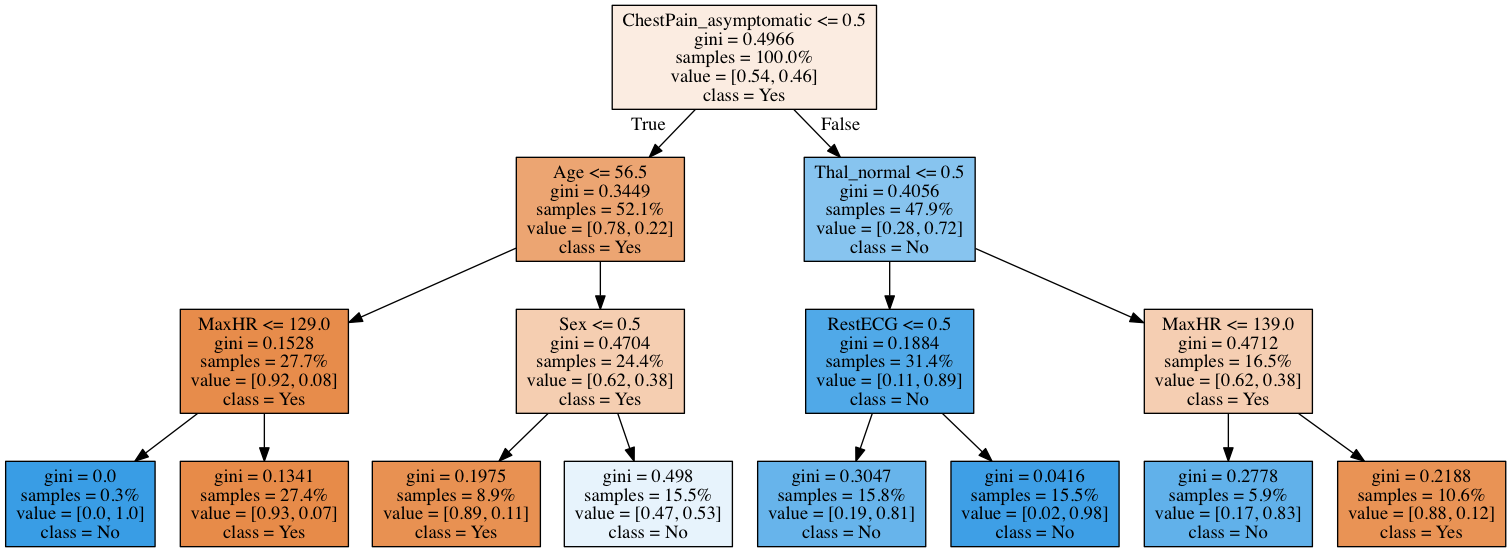

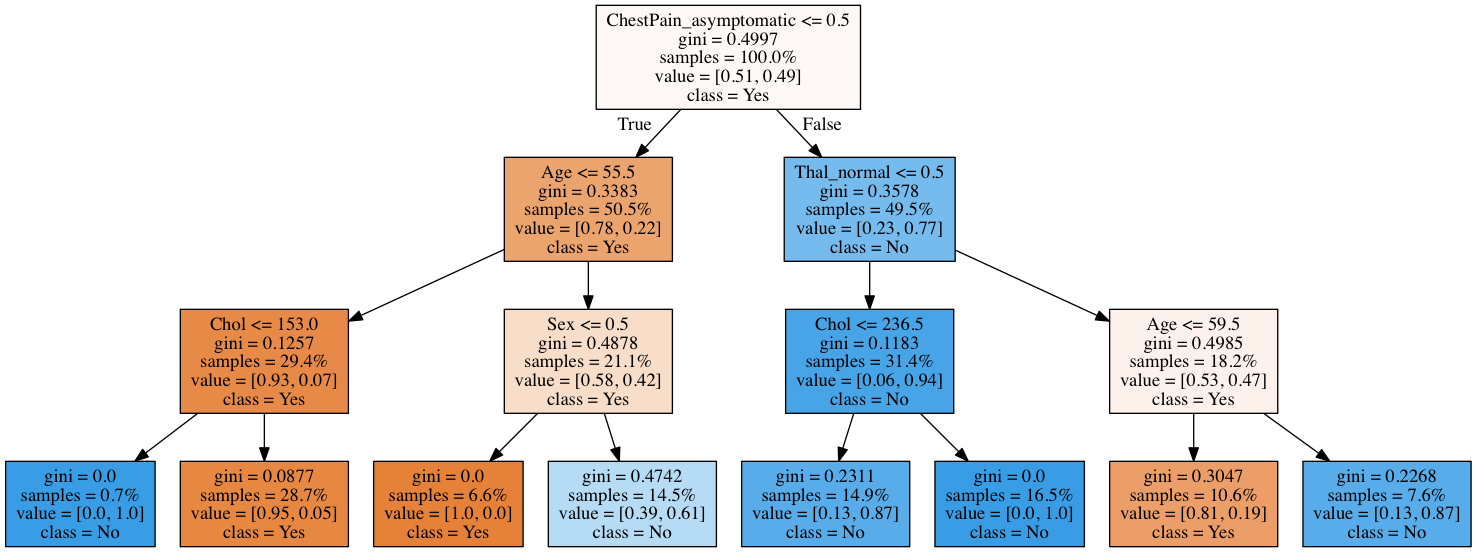

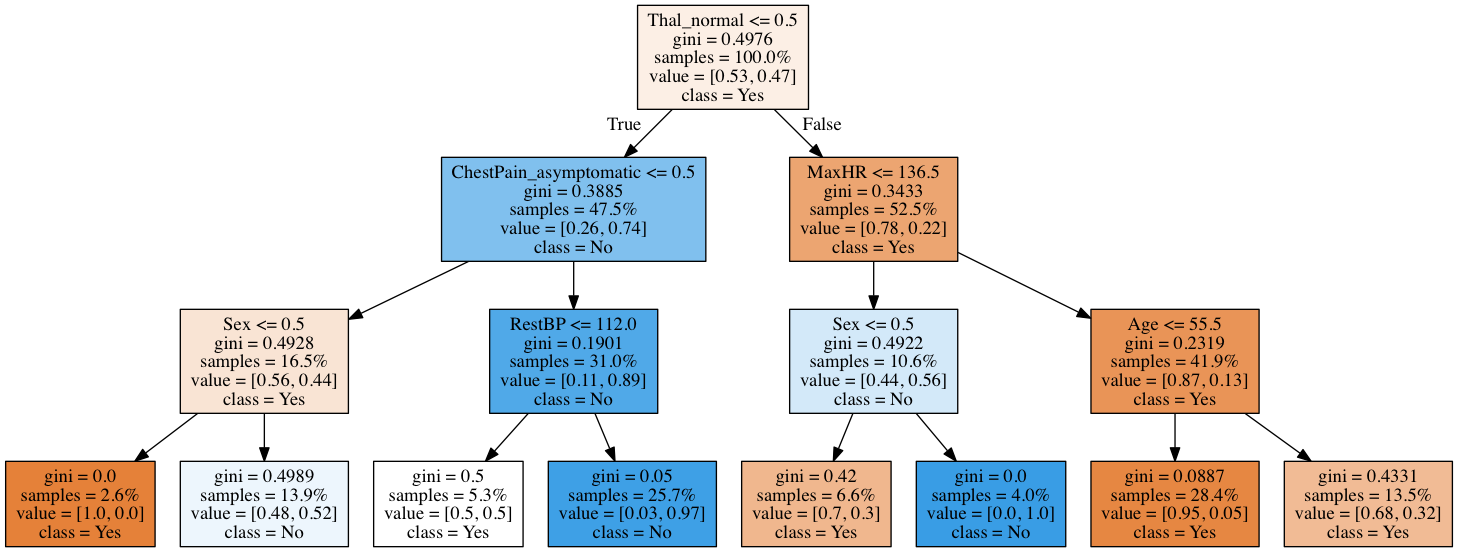

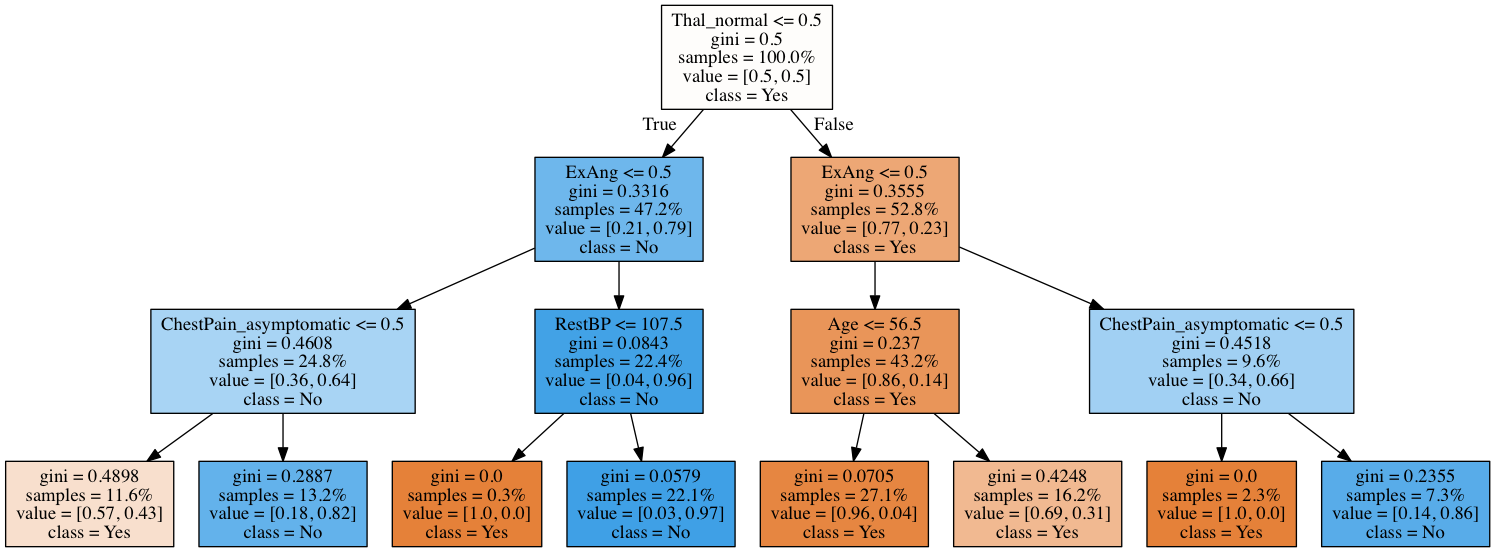

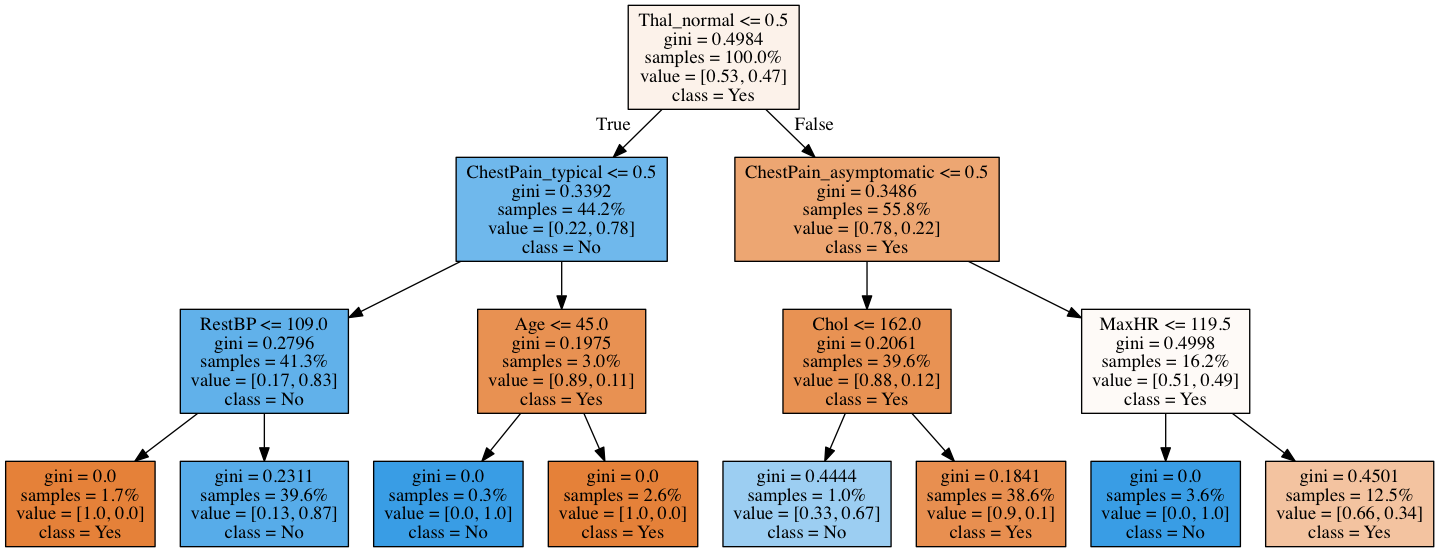

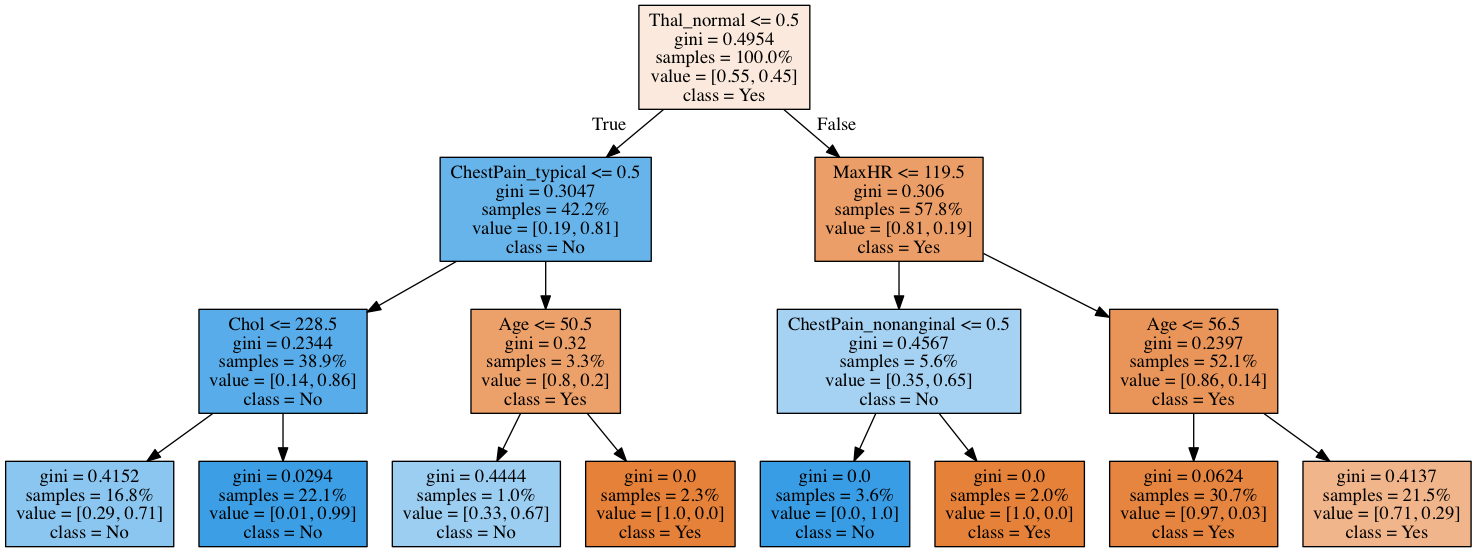

In [236]:
# Created nboots 
nboots = 10 
for nboots in np.arange(0,nboots):  
    
    idx = np.random.randint(len(X), size=len(X))
    Xb = X.iloc[idx, :]
    yb = np.array(y)[idx]
    
    bg = DecisionTreeClassifier(max_depth=3)
    bg.fit(Xb, yb)


    dummy_io = StringIO() 
    export_graphviz(bg, out_file = dummy_io, feature_names=X.columns,\
                    class_names=['Yes', 'No'], proportion=True, filled=True)
    (graph,)=pydot.graph_from_dot_data(dummy_io.getvalue())
    display(Image(graph.create_png()))


In [171]:
len(X)

303

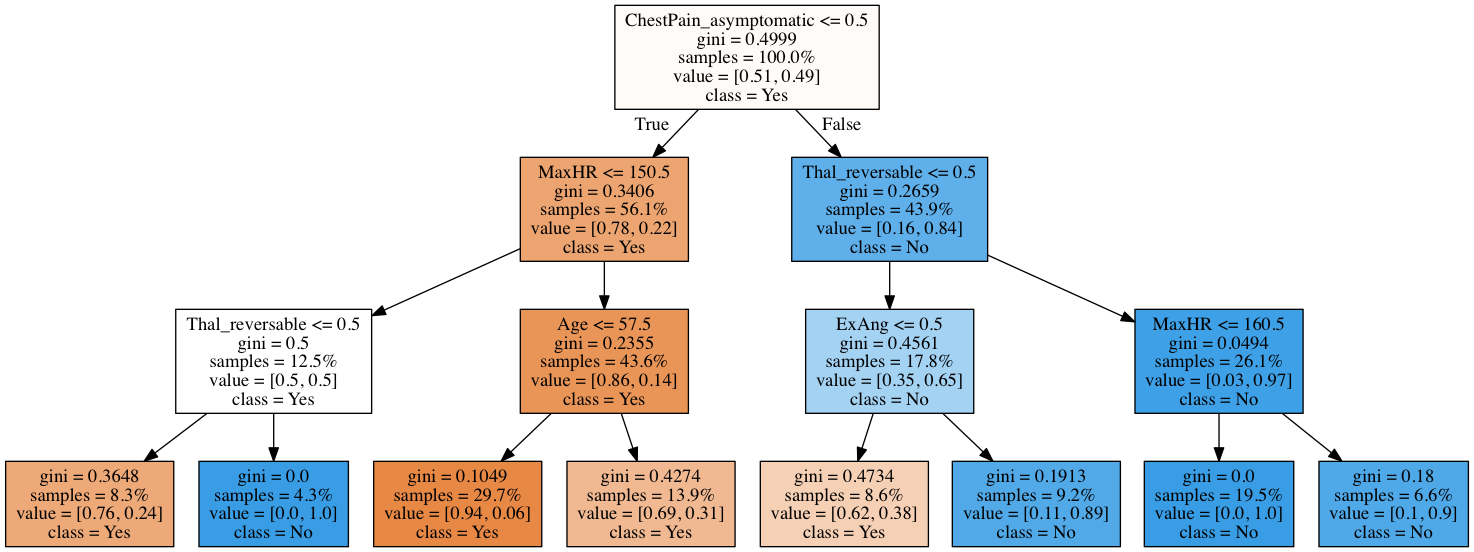

True

In [243]:
idx = np.random.randint(len(X), size=len(X))
Xb = X.iloc[idx, :]
yb = np.array(y)[idx]

bg = DecisionTreeClassifier(max_depth=3)
bg.fit(Xb, yb)


dummy_io = StringIO() 
export_graphviz(bg, out_file = dummy_io, feature_names=X.columns,\
                class_names=['Yes', 'No'], proportion=True, filled=True)
(graph,)=pydot.graph_from_dot_data(dummy_io.getvalue())
display(Image(graph.create_png()))


graph.write_png("fig/pruning_1")